# EXP: Autoencoder: PyTorch and MNIST

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns
import numpy as np

C:\Users\arjun\anaconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.12.1


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Specify hyper-parameters-
num_epochs = 50
batch_size = 256
learning_rate = 0.001

### MNIST data pre-processing

In [7]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [8]:
path_to_data = "C:\\Users\\arjun\Downloads\\"

In [9]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
    # root = './data', train = True,
    root = path_to_data + "data", train = True,
    transform = transforms_apply, download = True
)

test_dataset = torchvision.datasets.MNIST(
    # root = './data', train = False,
    root = path_to_data + "data", train = False,
    transform = transforms_apply
)

In [10]:
len(train_dataset.targets), len(train_dataset.data)

(60000, 60000)

In [11]:
len(test_dataset.targets), len(test_dataset.data)

(10000, 10000)

In [12]:
print(f"training dataset length/shape: {list(train_dataset.data.size())}")

training dataset length/shape: [60000, 28, 28]


In [13]:
print(f"mean = {train_dataset.data.float().mean() / 255:.4f}")
print(f"std dev = {train_dataset.data.float().std() / 255:.4f}")

mean = 0.1307
std dev = 0.3081


Note: Since MNIST has only one channel, therefore, the mean and standard deviation is computed for one channel!

In [14]:
# Sanity check-
train_dataset.data.min(), train_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [15]:
test_dataset.data.min(), test_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [16]:
# Scale pixel values in the range 0 to 1
# To manually convert the pixel values in the range 0 to 1, divide the training and testing
# datasets by 255.0-
train = train_dataset.data.float() / 255.0
test = test_dataset.data.float() / 255.0

In [17]:
# Reshape to include gray-scale channel-
train = train.reshape(60000, 1, 28, 28)
test = test.reshape(10000, 1, 28, 28)

In [18]:
train.shape, test.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [19]:
# Sanity check- min and max pixel values are in the range 0 to 1-
train.data.min(), train.data.max()

(tensor(0.), tensor(1.))

In [20]:
test.data.min(), test.data.max()

(tensor(0.), tensor(1.))

In [21]:
del train_dataset, test_dataset

In [22]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test, batch_size = batch_size,
    shuffle = False
)

In [23]:
print(f"Sizes of train_dataset: {len(train)} and test_dataet: {len(test)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 235 and test_loader: 40


In [24]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 235 & len(test_loader) = 40


In [25]:
# Sanity check-
len(train) / batch_size, len(test) / batch_size

(234.375, 39.0625)

In [26]:
# Get some random batch of training images & labels-
images = next(iter(train_loader))

# You get 64 images due to the specified batch size-
# print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")
print(f"images.shape: {images.shape}")

images.shape: torch.Size([256, 1, 28, 28])


In [27]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [28]:
# De-normalize the batch of images-
images *= 255.0

images.min(), images.max()

(tensor(0.), tensor(255.))

In [29]:
# Reshape images for visualization-
images = images.view(-1, 1, 28, 28)

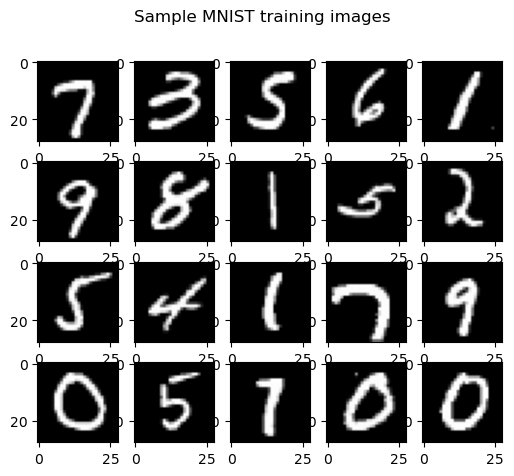

In [30]:
# Visualize 20 images from training set-
plt.figure(figsize = (6, 5))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

In [31]:
del images

### Define _Convolutional_ Autoencoder

In [32]:
class Conv_Encoder(nn.Module):
    def __init__(self, latent_space):
        super(Conv_Encoder, self).__init__()
        self.latent_space = latent_space
        
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 32,
            kernel_size = 3, stride = 1,
            padding = 0, bias = True
        )
        self.conv2 = nn.Conv2d(
            in_channels = 32, out_channels = 32,
            kernel_size = 3, stride = 1,
            padding = 0, bias = True
        )
        self.conv3 = nn.Conv2d(
            in_channels = 32, out_channels = 64,
            kernel_size = 3, stride = 2,
            padding = 0, bias = True
        )
        self.conv4 = nn.Conv2d(
            in_channels = 64, out_channels = 64,
            kernel_size = 3, stride = 1,
            padding = 0, bias = True
        )
        self.conv5 = nn.Conv2d(
            in_channels = 64, out_channels = 128,
            kernel_size = 3, stride = 1,
            padding = 0, bias = True
        )
        self.conv6 = nn.Conv2d(
            in_channels = 128, out_channels = 128,
            kernel_size = 3, stride = 2,
            padding = 0, bias = True
        )
        self.conv7 = nn.Conv2d(
            in_channels = 128, out_channels = 128,
            kernel_size = 3, stride = 1,
            padding = 0, bias = True
        )
        self.conv8 = nn.Conv2d(
            in_channels = 128, out_channels = self.latent_space,
            kernel_size = 1, stride = 1,
            padding = 0, bias = True)
        '''
        self.dense = nn.Linear(
            in_features = 128, out_features = 50,
            bias = True
        )
        self.dense2 = nn.Linear(
            in_features = 50, out_features = 10,
            bias = True
        )
        self.dense3 = nn.Linear(
            in_features = 10, out_features = self.latent_space,
            bias = True
        )
        '''
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        '''
        x = torch.flatten(x, start_dim = 1)
        x = F.relu(self.dense(x))
        x = F.relu(self.dense2(x))
        x = F.relu(self.dense3(x))
        '''
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = F.relu(self.conv1(x))
        print(f"conv1 output shape: {x.shape}")
        x = F.relu(self.conv2(x))
        print(f"conv2 output shape: {x.shape}")
        x = F.relu(self.conv3(x))
        print(f"conv3 output shape: {x.shape}")
        x = F.relu(self.conv4(x))
        print(f"conv4 output shape: {x.shape}")
        x = F.relu(self.conv5(x))
        print(f"conv5 output shape: {x.shape}")
        x = F.relu(self.conv6(x))
        print(f"conv6 output shape: {x.shape}")
        x = F.relu(self.conv7(x))
        print(f"conv7 output shape: {x.shape}")
        x = F.relu(self.conv8(x))
        print(f"conv8 output shape: {x.shape}")
        '''
        x = torch.flatten(x, start_dim = 1)
        print(f"flattened output shape: {x.shape}")
        x = F.relu(self.dense(x))
        print(f"dense output shape: {x.shape}")
        x = F.relu(self.dense2(x))
        print(f"dense2 output shape: {x.shape}")
        x = F.relu(self.dense3(x))
        '''
        print(f"encoder output shape: {x.shape}")
        return None
    

In [33]:
class Conv_Decoder(nn.Module):
    def __init__(self, latent_space):
        super(Conv_Decoder, self).__init__()
        
        self.latent_space = latent_space
        '''
        self.dense = nn.Linear(
            in_features = self.latent_space, out_features = 10,
            bias = True
        )
        self.dense2 = nn.Linear(
            in_features = 10, out_features = 50,
            bias = True
        )
        self.dense3 = nn.Linear(
            in_features = 50, out_features = 128,
            bias = True
        )
        '''
        self.conv_tran1 = nn.ConvTranspose2d(
            in_channels = self.latent_space, out_channels = 32,
            kernel_size = 3, stride = 1,
            padding = 0
        )
        self.conv_tran2 = nn.ConvTranspose2d(
            in_channels = 32, out_channels = 32,
            kernel_size = 3, stride = 1,
            padding = 1
        )
        self.conv_tran3 = nn.ConvTranspose2d(
            in_channels = 32, out_channels = 64,
            kernel_size = 3, stride = 2,
            padding = 0
        )
        self.conv_tran4 = nn.ConvTranspose2d(
            in_channels = 64, out_channels = 64,
            kernel_size = 3, stride = 1,
            padding = 1
        )
        self.conv_tran5 = nn.ConvTranspose2d(
            in_channels = 64, out_channels = 128,
            kernel_size = 3, stride = 1,
            padding = 0
        )
        self.conv_tran6 = nn.ConvTranspose2d(
            in_channels = 128, out_channels = 128,
            kernel_size = 3, stride = 1,
            padding = 0
        )
        self.conv_tran7 = nn.ConvTranspose2d(
            in_channels = 128, out_channels = 256,
            kernel_size = 3, stride = 2,
            padding = 0
        )
        self.conv_tran8 = nn.ConvTranspose2d(
            in_channels = 256, out_channels = 256,
            kernel_size = 3, stride = 1,
            padding = 0
        )
        self.conv_tran9 = nn.ConvTranspose2d(
            in_channels = 256, out_channels = 64,
            kernel_size = 3, stride = 1,
            padding = 0
        )
        self.conv_tran10 = nn.ConvTranspose2d(
            in_channels = 64, out_channels = 1,
            kernel_size = 2, stride = 1,
            padding = 0
        )
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        '''
        x = self.dense(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = x.view(-1, 128, 1, 1)
        '''
        x = F.relu(self.conv_tran1(x))
        x = F.relu(self.conv_tran2(x))
        x = F.relu(self.conv_tran3(x))
        x = F.relu(self.conv_tran4(x))
        x = F.relu(self.conv_tran5(x))
        x = F.relu(self.conv_tran6(x))
        x = F.relu(self.conv_tran7(x))
        x = F.relu(self.conv_tran8(x))
        x = F.relu(self.conv_tran9(x))
        # Use sigmoid activation function due to data pre-processing-
        x = torch.sigmoid(self.conv_tran10(x))
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        '''
        x = self.dense(x)
        print(f"dense output shape: {x.shape}")
        x = self.dense2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.dense3(x)
        print(f"dense3 output shape: {x.shape}")
        '''
        x = self.conv_tran1(x)
        print(f"conv transpose1 output shape: {x.shape}")
        x = self.conv_tran2(x)
        print(f"conv transpose2 output shape: {x.shape}")
        x = self.conv_tran3(x)
        print(f"conv transpose3 output shape: {x.shape}")
        x = self.conv_tran4(x)
        print(f"conv transpose4 output shape: {x.shape}")
        x = self.conv_tran5(x)
        print(f"conv transpose5 output shape: {x.shape}")
        x = self.conv_tran6(x)
        print(f"conv transpose6 output shape: {x.shape}")
        x = self.conv_tran7(x)
        print(f"conv transpose7 output shape: {x.shape}")
        x = self.conv_tran8(x)
        print(f"conv transpose8 output shape: {x.shape}")
        x = self.conv_tran9(x)
        print(f"conv transpose9 output shape: {x.shape}")
        x = self.conv_tran10(x)
        print(f"conv transpose10 output shape: {x.shape}")
        return None
        

In [34]:
class Conv_Autoencoder(nn.Module):
    def __init__(self, latent_space = 5):
        super(Conv_Autoencoder, self).__init__()
        self.latent_space = latent_space
        
        self.encoder = Conv_Encoder(latent_space = self.latent_space)
        self.decoder = Conv_Decoder(latent_space = self.latent_space)
    
    
    def forward(self, x):
        x_enc = self.encoder(x)
        return self.decoder(x_enc)
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.encoder(x)
        print(f"Encoder output shape: {x.shape}")
        x = self.decoder(x)
        print(f"Decoder output shape: {x.shape}")
        return None
    

In [35]:
# Initialize Conv Autoencoder-
model = Conv_Autoencoder(latent_space = 3).to(device)

In [36]:
# Sanity check-
images = next(iter(train_loader))
images = images.to(device)
images.shape

torch.Size([256, 1, 28, 28])

In [37]:
# Get reconstructions-
output = model(images)

In [38]:
# Sanity check-
output.shape, images.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256, 1, 28, 28]))

In [39]:
model.shape_computation(images)

Input shape: torch.Size([256, 1, 28, 28])
Encoder output shape: torch.Size([256, 3, 1, 1])
Decoder output shape: torch.Size([256, 1, 28, 28])


In [40]:
model.encoder.shape_computation(images)

Input shape: torch.Size([256, 1, 28, 28])
conv1 output shape: torch.Size([256, 32, 26, 26])
conv2 output shape: torch.Size([256, 32, 24, 24])
conv3 output shape: torch.Size([256, 64, 11, 11])
conv4 output shape: torch.Size([256, 64, 9, 9])
conv5 output shape: torch.Size([256, 128, 7, 7])
conv6 output shape: torch.Size([256, 128, 3, 3])
conv7 output shape: torch.Size([256, 128, 1, 1])
conv8 output shape: torch.Size([256, 3, 1, 1])
encoder output shape: torch.Size([256, 3, 1, 1])


In [41]:
images_enc = model.encoder(images)

In [42]:
model.decoder.shape_computation(images_enc)

Input shape: torch.Size([256, 3, 1, 1])
conv transpose1 output shape: torch.Size([256, 32, 3, 3])
conv transpose2 output shape: torch.Size([256, 32, 3, 3])
conv transpose3 output shape: torch.Size([256, 64, 7, 7])
conv transpose4 output shape: torch.Size([256, 64, 7, 7])
conv transpose5 output shape: torch.Size([256, 128, 9, 9])
conv transpose6 output shape: torch.Size([256, 128, 11, 11])
conv transpose7 output shape: torch.Size([256, 256, 23, 23])
conv transpose8 output shape: torch.Size([256, 256, 25, 25])
conv transpose9 output shape: torch.Size([256, 64, 27, 27])
conv transpose10 output shape: torch.Size([256, 1, 28, 28])


In [43]:
del images, images_enc, output

In [44]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([32, 1, 3, 3]) has 288 parameters
layer.shape = torch.Size([32]) has 32 parameters
layer.shape = torch.Size([32, 32, 3, 3]) has 9216 parameters
layer.shape = torch.Size([32]) has 32 parameters
layer.shape = torch.Size([64, 32, 3, 3]) has 18432 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([128, 64, 3, 3]) has 73728 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128, 128, 3, 3]) has 147456 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128, 128, 3, 3]) has 147456 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([3, 128, 1, 1]) has 384 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 32, 3, 3]) has 864 parameters
layer.shape = torch.Size([32]) has 32 parameters

In [45]:
print(f"Total number of parameters in Conv Autoencoder model = {tot_params}")

Total number of parameters in Conv Autoencoder model = 1754436


In [46]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [47]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [48]:
# Define reconstruction loss as MSE-
reconstruction_loss_fn = F.mse_loss

In [49]:
def train_one_epoch(model, dataloader):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to reconstruction loss-
    running_recon_loss = 0.0
    
    for i, data in tqdm(
        enumerate(dataloader),
        total = int(len(train) / dataloader.batch_size)
        ):
        
        # Push data samples to device-
        data = data.to(device)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Get reconstructions-
        recon_data = model(data)
        
        # Compute reconstruction loss-
        recon_loss = reconstruction_loss_fn(data, recon_data)
        
        # Compute gradienst wrt computed loss-
        recon_loss.backward()
        
        # Perform one step of gradient descent-
        optimizer.step()
        
        # Compute total reconstruction loss-
        running_recon_loss += recon_loss.cpu().detach().numpy()
        
    # Compute loss as float value-
    recon_loss = running_recon_loss / len(dataloader.dataset)

    return recon_loss


In [50]:
def validate_one_epoch(model, dataloader):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_recon_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            total = int(len(test) / test_loader.batch_size)):
        
            # Push data points to 'device'-
            data = data.to(device)
            
            # Forward propagation-
            recon_data = model(data)
            
            # Compute reconstruction loss-
            recon_loss = reconstruction_loss_fn(data, recon_data)
            
            # Compute total reconstruction loss-
            running_recon_loss += recon_loss.cpu().detach().numpy()
                
    val_recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return val_recon_loss


In [51]:
# Python dict to contain training metrics-
train_history = {}

In [52]:
print(f"Training Conv-AE model for {num_epochs} epochs")

Training Conv-AE model for 50 epochs


In [56]:
# To save 'best' parameters-
best_val_loss = 10000

In [57]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 10e-5
patience = 3
loc_patience = 0

In [58]:
for epoch in range(1, num_epochs + 1):
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    
    # Train model for 1 epoch-
    train_loss = train_one_epoch(model = model, dataloader = train_loader)
    
    # Get validation after 1 epoch-
    val_loss = validate_one_epoch(model = model, dataloader = test_loader)
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss, 'val_loss': val_loss
    }
    
    print(f"Epoch = {epoch}; train loss = {train_loss:.6f} &",
          f", val loss = {val_loss:.6f}"
         )
    
    
    # Save 'best' parameters-
    if (val_loss < best_val_loss):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "Conv_AE_MNIST_best_model.pth")
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
        

235it [00:17, 13.14it/s]                                                                                               
40it [00:01, 38.39it/s]                                                                                                


Epoch = 1; train loss = 0.000148 & , val loss = 0.000142
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.28it/s]                                                                                               
40it [00:01, 38.64it/s]                                                                                                


Epoch = 2; train loss = 0.000135 & , val loss = 0.000133
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.52it/s]                                                                                               
40it [00:01, 38.86it/s]                                                                                                


Epoch = 3; train loss = 0.000128 & , val loss = 0.000130
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.52it/s]                                                                                               
40it [00:01, 38.92it/s]                                                                                                


Epoch = 4; train loss = 0.000124 & , val loss = 0.000126
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.53it/s]                                                                                               
40it [00:01, 38.96it/s]                                                                                                


Epoch = 5; train loss = 0.000121 & , val loss = 0.000124
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.52it/s]                                                                                               
40it [00:01, 38.96it/s]                                                                                                


Epoch = 6; train loss = 0.000119 & , val loss = 0.000122
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.55it/s]                                                                                               
40it [00:01, 39.02it/s]                                                                                                


Epoch = 7; train loss = 0.000117 & , val loss = 0.000121
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.56it/s]                                                                                               
40it [00:01, 39.01it/s]                                                                                                


Epoch = 8; train loss = 0.000116 & , val loss = 0.000119
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.56it/s]                                                                                               
40it [00:01, 39.02it/s]                                                                                                


Epoch = 9; train loss = 0.000115 & , val loss = 0.000120


235it [00:17, 13.56it/s]                                                                                               
40it [00:01, 38.79it/s]                                                                                                


Epoch = 10; train loss = 0.000114 & , val loss = 0.000117
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.09it/s]                                                                                                


Epoch = 11; train loss = 0.000113 & , val loss = 0.000119


235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.05it/s]                                                                                                


Epoch = 12; train loss = 0.000112 & , val loss = 0.000117
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.56it/s]                                                                                               
40it [00:01, 39.09it/s]                                                                                                


Epoch = 13; train loss = 0.000111 & , val loss = 0.000116
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.09it/s]                                                                                                


Epoch = 14; train loss = 0.000111 & , val loss = 0.000115
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 38.91it/s]                                                                                                


Epoch = 15; train loss = 0.000110 & , val loss = 0.000115
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.02it/s]                                                                                                


Epoch = 16; train loss = 0.000110 & , val loss = 0.000114
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.06it/s]                                                                                                


Epoch = 17; train loss = 0.000109 & , val loss = 0.000114


235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 38.98it/s]                                                                                                


Epoch = 18; train loss = 0.000109 & , val loss = 0.000114
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.00it/s]                                                                                                


Epoch = 19; train loss = 0.000108 & , val loss = 0.000114


235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.07it/s]                                                                                                


Epoch = 20; train loss = 0.000108 & , val loss = 0.000115


235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.11it/s]                                                                                                


Epoch = 21; train loss = 0.000108 & , val loss = 0.000114
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.13it/s]                                                                                                


Epoch = 22; train loss = 0.000107 & , val loss = 0.000114
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.09it/s]                                                                                                


Epoch = 23; train loss = 0.000106 & , val loss = 0.000113
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.09it/s]                                                                                                


Epoch = 24; train loss = 0.000106 & , val loss = 0.000113
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.58it/s]                                                                                               
40it [00:01, 39.07it/s]                                                                                                


Epoch = 25; train loss = 0.000105 & , val loss = 0.000112
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.21it/s]                                                                                                


Epoch = 26; train loss = 0.000105 & , val loss = 0.000114


235it [00:17, 13.57it/s]                                                                                               
40it [00:01, 39.02it/s]                                                                                                


Epoch = 27; train loss = 0.000105 & , val loss = 0.000112


235it [00:17, 13.59it/s]                                                                                               
40it [00:01, 39.09it/s]                                                                                                


Epoch = 28; train loss = 0.000105 & , val loss = 0.000111
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.59it/s]                                                                                               
40it [00:01, 39.05it/s]                                                                                                


Epoch = 29; train loss = 0.000104 & , val loss = 0.000111
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.58it/s]                                                                                               
40it [00:01, 39.09it/s]                                                                                                


Epoch = 30; train loss = 0.000104 & , val loss = 0.000112


235it [00:17, 13.59it/s]                                                                                               
40it [00:01, 39.05it/s]                                                                                                


Epoch = 31; train loss = 0.000104 & , val loss = 0.000111


235it [00:17, 13.58it/s]                                                                                               
40it [00:01, 39.04it/s]                                                                                                


Epoch = 32; train loss = 0.000104 & , val loss = 0.000111
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.59it/s]                                                                                               
40it [00:01, 39.09it/s]                                                                                                


Epoch = 33; train loss = 0.000103 & , val loss = 0.000111


235it [00:17, 13.58it/s]                                                                                               
40it [00:01, 39.04it/s]                                                                                                


Epoch = 34; train loss = 0.000103 & , val loss = 0.000111
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.58it/s]                                                                                               
40it [00:01, 39.01it/s]                                                                                                


Epoch = 35; train loss = 0.000103 & , val loss = 0.000110
Saving model with lowest val_loss = 0.0001



235it [00:17, 13.58it/s]                                                                                               
40it [00:01, 38.92it/s]                                                                                                


Epoch = 36; train loss = 0.000103 & , val loss = 0.000113


235it [00:17, 13.58it/s]                                                                                               
40it [00:01, 39.09it/s]                                                                                                


Epoch = 37; train loss = 0.000103 & , val loss = 0.000111


235it [00:17, 13.59it/s]                                                                                               
40it [00:01, 39.05it/s]                                                                                                

Epoch = 38; train loss = 0.000102 & , val loss = 0.000113

'EarlyStopping' called!



In [59]:
import pickle

# Save training history as pickle file-
with open("Conv_AE_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

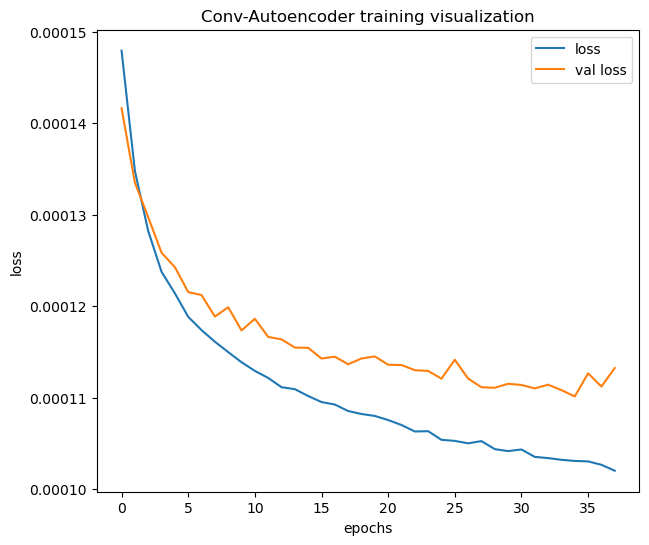

In [73]:
plt.figure(figsize = (7, 6))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conv-Autoencoder training visualization")
plt.legend(loc = 'best')
plt.show()

In [60]:
# Load trained weights from before-
trained_model = Conv_Autoencoder(latent_space = 3).to(device)
trained_model.load_state_dict(torch.load('Conv_AE_MNIST_best_model.pth'))
# trained_model.load_state_dict(torch.load('Conv_AE_MNIST_best_model.pth', map_location = torch.device('cpu')))

<All keys matched successfully>

In [61]:
# Sanity check-
images = next(iter(test_loader)).to(device)

In [62]:
# Get reconstructions-
output = trained_model(images)

In [63]:
# Sanity check-
output.shape, images.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256, 1, 28, 28]))

In [64]:
output.min(), output.max()

(tensor(0., device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.9977, device='cuda:0', grad_fn=<MaxBackward1>))

In [65]:
# De-normalize the batch of images-
output *= 255.0

output.min(), output.max()

(tensor(0., device='cuda:0', grad_fn=<MinBackward1>),
 tensor(254.4247, device='cuda:0', grad_fn=<MaxBackward1>))

In [66]:
# Reshape images for visualization-
output = output.view(-1, 1, 28, 28)

In [67]:
output = output.cpu().detach().numpy()

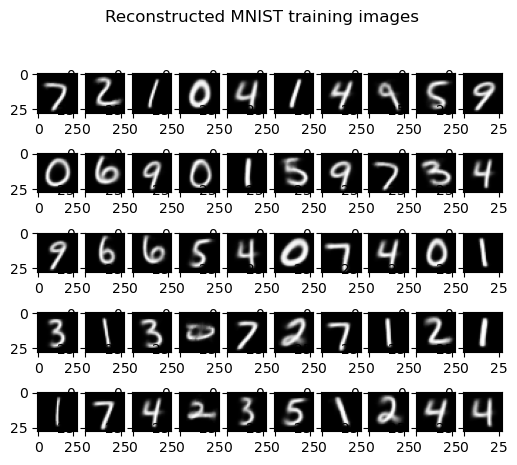

In [100]:
# Visualize 50 images from training set-
plt.figure(figsize = (6, 5))
for i in range(50):
    # 5 rows & 10 columns-
    plt.subplot(5, 10, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(output[i][0], cmap = 'gray')
    
plt.suptitle("Reconstructed MNIST training images")
plt.show()

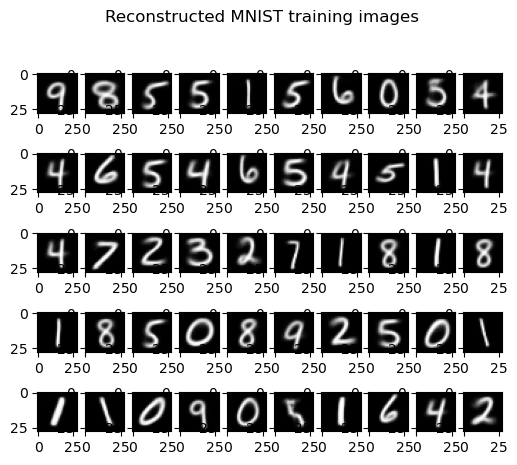

In [101]:
# Visualize 50 images from training set-
plt.figure(figsize = (6, 5))
for i in range(50):
    # 5 rows & 10 columns-
    plt.subplot(5, 10, i + 1)
    plt.imshow(output[150 + i][0], cmap = 'gray')
    
plt.suptitle("Reconstructed MNIST training images")
plt.show()

In [94]:
# Python list to contain encoded vectors-
val_images_enc = []

In [95]:
# Get encoded representations-
for images in test_loader:
    images = images.to(device)
    images_enc = trained_model.encoder(images)
    images_enc = images_enc.detach().cpu().numpy()
    images_enc = images_enc.reshape(-1, 3)
    val_images_enc.append(images_enc)

In [96]:
val_images_enc = np.vstack(val_images_enc)

In [97]:
val_images_enc.shape

(10000, 3)

In [ ]:
# Visualize latent space for encoded data-
fig = px.scatter_3d(
    x = val_images_enc[:, 0], y = val_images_enc[:, 1],
    z = val_images_enc[:, 2],
    # color = y_train
    )
fig.show()

In [104]:
z = torch.randn(10000, 3).cpu().detach().numpy()

In [105]:
z.shape, val_images_enc.shape

((10000, 3), (10000, 3))

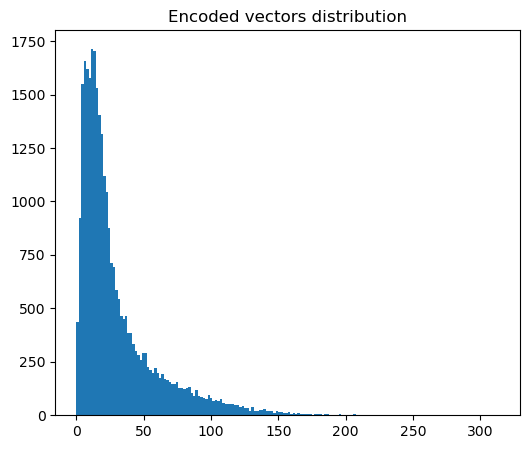

In [116]:
plt.figure(figsize = (6, 5))
n, b, _ = plt.hist(val_images_enc.flatten(), bins = int(np.ceil(np.sqrt(val_images_enc.size))))
plt.title("Encoded vectors distribution")
plt.show()

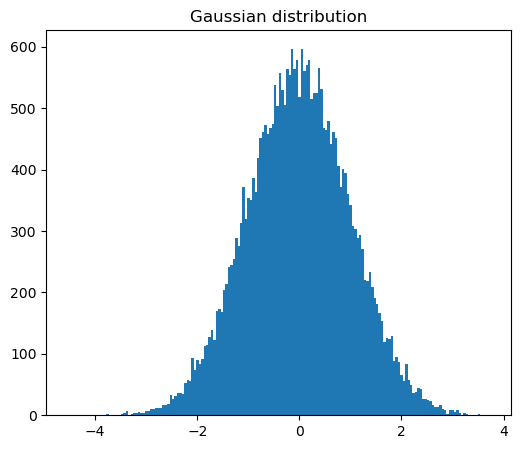

In [117]:
plt.figure(figsize = (6, 5))
n, b, _ = plt.hist(z.flatten(), bins = int(np.ceil(np.sqrt(z.size))))
plt.title("Gaussian distribution")
plt.show()